In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import torchvision.transforms as transforms
import tqdm
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
import sys
sys.path.append("..")

In [3]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]["filename"]
        self.all_images_index = self.csv[:]["ind"]
        self.all_labels = np.array(self.csv.drop(["filename", "ind"], axis=1))
        self.train_ratio = int(0.6 * len(self.csv))
        self.valid_ratio = int(0.2 * len(self.csv))
        self.test_ratio =  len(self.csv) - self.train_ratio - self.valid_ratio
 
        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[: self.train_ratio])
            self.labels = list(self.all_labels[: self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                ]
            )
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[self.train_ratio : self.train_ratio+self.valid_ratio])
            self.labels = list(self.all_labels[self.train_ratio : self.train_ratio+self.valid_ratio])
#             # define the validation transforms
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                ]
            )
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            print(f"Number of validation images: {self.test_ratio}")
            self.image_names = list(self.all_image_names[-self.test_ratio:])
            self.labels = list(self.all_labels[-self.test_ratio:])
            # define the test transforms
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                ]
            )

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image = cv2.imread(f"../data/raw_images/{self.image_names[index]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]

        return {
            "image": torch.tensor(image, dtype=torch.float32),
            "label": torch.tensor(targets, dtype=torch.float32),
        }

In [4]:
class mlp(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(mlp , self).__init__()

        self.layer1 = nn.Linear(  input_size   , hidden_size1  )
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2  )
        self.layer3 = nn.Linear(  hidden_size2 , output_size  )        
        
    def forward(self, x):
        x = x.view(-1, 110592)
        y       = self.layer1(x)
        y_hat   = F.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = F.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores
    
# 3 x 144 x 256 = 110592

In [5]:
def get_error( outputs , labels, batch_size):
    lab = torch.where(outputs>=0.5,1,0)
    indicator = torch.where(lab!=labels, 1, 0)
    non_matches=torch.sum(indicator, axis=0)
    error = non_matches.float()/batch_size
    error = error.sum() / 6
    return error.item()

In [6]:
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print("Training")
    model.train()
    counter = 0
    train_running_loss = 0.0
    train_running_error = 0.0
    for i, data in tqdm(
        enumerate(dataloader), total=int(len(train_data) / dataloader.batch_size)
    ):
        
        counter += 1
        data, target = data["image"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.detach().item()
        error = get_error( outputs.detach() , target, batch_size)
        train_running_error += error
        
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()

        
    train_loss = train_running_loss / counter
    total_error = train_running_error/counter
    return train_loss, total_error

In [7]:
def validate(model, dataloader, criterion, val_data, device):
    print("Validating")
    model.eval()
    counter = 0
    val_running_loss = 0.0
    val_running_error = 0.0
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader), total=int(len(val_data) / dataloader.batch_size)
        ):
            counter += 1
            data, target = data["image"].to(device), data["label"].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
            error = get_error( outputs, target, batch_size)
            val_running_error += error
        val_loss = val_running_loss / counter
        val_error = val_running_error / counter
    return val_loss, val_error

In [8]:
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('There are {} ({:.2f} million) parameters in this neural network'.format(
        nb_param, nb_param/1e6)
         )

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader

matplotlib.style.use("ggplot")
# initialize the computation device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# input_size, hidden_size1, hidden_size2, and output_size
input_size = 110592
hidden_size1 = 500
hidden_size2 = 500
output_size = 6

model = mlp(input_size, hidden_size1,hidden_size2,output_size)
model = model.to(device)
print(model)
display_num_param(model)
lr = 0.0001
epochs = 10
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()

mlp(
  (layer1): Linear(in_features=110592, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=500, bias=True)
  (layer3): Linear(in_features=500, out_features=6, bias=True)
)
There are 55550006 (55.55 million) parameters in this neural network


In [11]:
train_csv = pd.read_csv("../data/processed/train.csv")
# train dataset
# train_csv_sample = train_csv.sample(frac=1, random_state=1)
train_csv_sample = train_csv
train_data = ImageDataset(train_csv_sample[:2000], train=True, test=False)
# validation dataset
valid_data = ImageDataset(train_csv_sample[:2000], train=False, test=False)
# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)



Number of training images: 1199
Number of validation images: 399


In [12]:
img = cv2.imread(f"./data/raw_images/0_8wewPn7TZfs_0.jpg")


img = train_data.__getitem__(0)
print(img["image"].shape)


torch.Size([3, 144, 256])


C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [13]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, total_epoch_error = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss, valid_epoch_error = validate(model, valid_loader, criterion, valid_data, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print("Train Error: ", total_epoch_error)
    print(f"Val Loss: {valid_epoch_loss:.4f}")
    print(f"Val Error: ", valid_epoch_error)
    

Epoch 1 of 10
Training


  0%|                                                                                           | 0/37 [00:00<?, ?it/s]C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
38it [00:03, 10.73it/s]                                                                                                


Validating


13it [00:00, 14.45it/s]                                                                                                


Train Loss: 0.4208
Train Error:  0.17680921523194565
Val Loss: 0.5042
Val Error:  0.19310897646042016
Epoch 2 of 10
Training


38it [00:02, 13.31it/s]                                                                                                


Validating


13it [00:01, 12.91it/s]                                                                                                


Train Loss: 0.2888
Train Error:  0.11239035358946574
Val Loss: 0.6125
Val Error:  0.20272436508765587
Epoch 3 of 10
Training


38it [00:03, 12.40it/s]                                                                                                


Validating


13it [00:00, 15.67it/s]                                                                                                


Train Loss: 0.2317
Train Error:  0.09114583630702998
Val Loss: 0.5440
Val Error:  0.2455929586520562
Epoch 4 of 10
Training


38it [00:02, 12.94it/s]                                                                                                


Validating


13it [00:00, 13.38it/s]                                                                                                


Train Loss: 0.1924
Train Error:  0.07182017703981776
Val Loss: 0.5310
Val Error:  0.19070513431842512
Epoch 5 of 10
Training


38it [00:03, 12.66it/s]                                                                                                


Validating


13it [00:00, 13.30it/s]                                                                                                


Train Loss: 0.1500
Train Error:  0.0516721504789434
Val Loss: 0.6019
Val Error:  0.2620192376466898
Epoch 6 of 10
Training


38it [00:02, 15.27it/s]                                                                                                


Validating


13it [00:00, 23.74it/s]                                                                                                


Train Loss: 0.1326
Train Error:  0.04769736984254498
Val Loss: 0.6199
Val Error:  0.2600160321364036
Epoch 7 of 10
Training


38it [00:03, 12.49it/s]                                                                                                


Validating


13it [00:00, 13.23it/s]                                                                                                


Train Loss: 0.1076
Train Error:  0.03440241317117685
Val Loss: 0.6663
Val Error:  0.22235577610822824
Epoch 8 of 10
Training


38it [00:02, 13.82it/s]                                                                                                


Validating


13it [00:01, 12.77it/s]                                                                                                


Train Loss: 0.0935
Train Error:  0.030290571188456135
Val Loss: 0.7107
Val Error:  0.18349359643000823
Epoch 9 of 10
Training


38it [00:03, 12.51it/s]                                                                                                


Validating


13it [00:01, 11.95it/s]                                                                                                


Train Loss: 0.0779
Train Error:  0.02576754448053084
Val Loss: 0.8148
Val Error:  0.24839744315697596
Epoch 10 of 10
Training


38it [00:03, 12.35it/s]                                                                                                


Validating


13it [00:00, 13.69it/s]                                                                                                

Train Loss: 0.0666
Train Error:  0.020833333819418362
Val Loss: 0.7279
Val Error:  0.23076923879293296


In [14]:
# test_csv = pd.read_csv("../data/processed/test/test.csv")
actors = train_csv.columns.values[2:]
print('actors: ', actors)
# prepare the test dataset and dataloader
test_data = ImageDataset(train_csv_sample[:2000], train=False, test=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

actors:  ['chandler' 'joey' 'monica' 'phoebe' 'rachel' 'ross']
Number of validation images: 401


C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


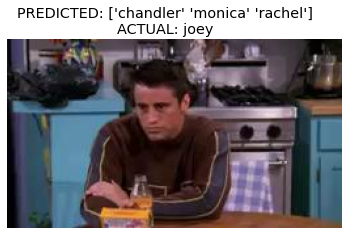

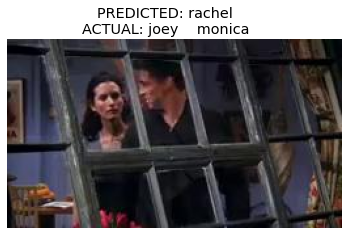

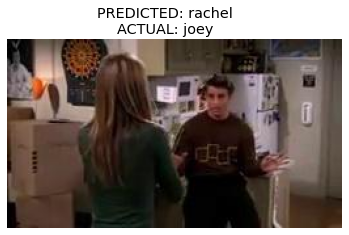

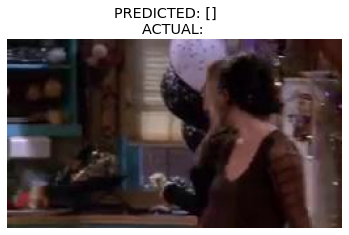

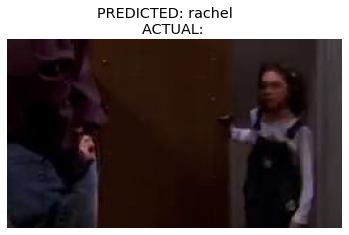

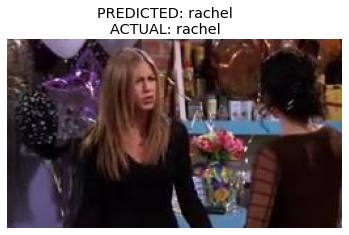

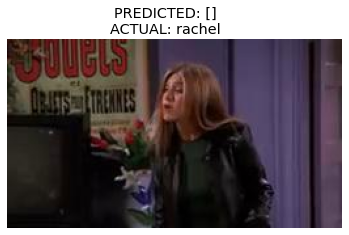

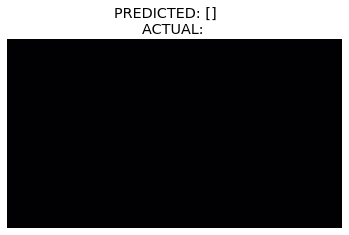

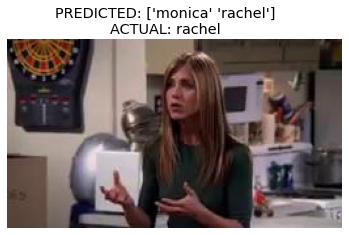

Test Error:  0.2541666726768017


In [17]:
model.eval()
test_running_error = 0.0
for counter, data in enumerate(test_loader):
    
    image, target = data["image"].to(device), data["label"]
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]
#     print('target_indices: ', target_indices)
    # get the predictions by passing the image through the model
    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    lab = torch.where(outputs>=0.5,1,0)[0]
#     print('lab: ', lab)
    pred = torch.where(lab==1)
#     print('pred: ', pred)
    error = get_error( outputs, target, 1)
    #         print('error: ',error)
    test_running_error += error
    
    string_predicted = ""
    string_actual = ""
    for i in range(len(pred)):
        string_predicted += f"{actors[pred[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{actors[target_indices[i]]}    "
        
#     print('image shape: ', image.shape)
    if 10< counter < 20:
        image = image.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        plt.show()
    
test_error = test_running_error / counter
print(f"Test Error: ", test_error)